## Credit Card Fraud Kaggle Project

Logistic Regression and a random forest model to predict fraudulent transactions on credit card data. 

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from geopy.distance import geodesic
import math
import IPython
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, classification_report
import warnings
warnings.filterwarnings('ignore')

In [51]:

urls = [
    "https://raw.githubusercontent.com/rokibulroni/Phishing-Email-Dataset/refs/heads/main/CEAS_08.csv",
    "https://raw.githubusercontent.com/rokibulroni/Phishing-Email-Dataset/refs/heads/main/Nazario.csv",
    "https://raw.githubusercontent.com/rokibulroni/Phishing-Email-Dataset/refs/heads/main/Nigerian_Fraud.csv",
    "https://github.com/rokibulroni/Phishing-Email-Dataset/raw/refs/heads/main/SpamAssasin.csv"
]


df = pd.concat([pd.read_csv(url) for url in urls], ignore_index=True)
#df = pd.read_csv("https://github.com/rokibulroni/Phishing-Email-Dataset/raw/refs/heads/main/SpamAssasin.csv")




In [52]:
df

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1
...,...,...,...,...,...,...,...
49855,Professional_Career_Development_Institute@Frug...,yyyy@netnoteinc.com,"Tue, 3 Dec 2002 13:19:58 -0800",Busy? Home Study Makes Sense!,\n\n \n--- \n![](http://images.pcdi-homestud...,1,1
49856,"""IQ - TBA"" <tba@insiq.us>",<yyyy@spamassassin.taint.org>,"Tue, 3 Dec 2002 18:52:29 -0500",Preferred Non-Smoker Rates for Smokers,This is a multi-part message in MIME format. -...,1,1
49857,Mike <raye@yahoo.lv>,Mailing.List@user2.pro-ns.net,"Sun, 20 Jul 2003 16:19:44 +0800","How to get 10,000 FREE hits per day to any web...","Dear Subscriber,\n\nIf I could show you a way ...",1,1
49858,"""Mr. Clean"" <cweqx@dialix.oz.au>",<Undisclosed.Recipients@webnote.net>,"Wed, 05 Aug 2020 04:01:50 -1900",Cannabis Difference,****Mid-Summer Customer Appreciation SALE!****...,1,0


In [53]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49860 entries, 0 to 49859
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    49529 non-null  object
 1   receiver  47768 non-null  object
 2   date      49377 non-null  object
 3   subject   49773 non-null  object
 4   body      49859 non-null  object
 5   label     49860 non-null  int64 
 6   urls      49860 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.7+ MB
None


In [54]:
#Value counts show that the data is imbalanced. Which is what would be expected for fraudulent activity.
df['label'].value_counts()

label
1    28457
0    21403
Name: count, dtype: int64

In [55]:
#Dropping the two observations that are not a 0 or 1 but also have a timestamp.
# df = df[df['label'].isin(['1', '0'])]


In [56]:
#Deleting trans_num, city_pop, city, and state as we don't want these values in the model
# del df['trans_num']
# del df['city']
# del df['state']

#### Feature Engineering

In [58]:
# #Creating an age category
# df['dob'][0]
# df['age'] = (pd.to_datetime(df['trans_date_trans_time'], format="%d-%m-%Y %H:%M") - 
#              pd.to_datetime(df['dob'], format="%d-%m-%Y")).dt.days // 365

# # Extracting the time of the day
# df['trans_date_trans_time'][0]
# df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format="%d-%m-%Y %H:%M")
# df['time_of_day'] = df['trans_date_trans_time'].dt.strftime('%H:%M')

# # Hour of Day
# df['hour'] = df['trans_date_trans_time'].dt.hour

# #Extracting day of the week.
# df['day_of_week'] = df['trans_date_trans_time'].dt.day_name()

# #Create a new measure of the distance between lat and long and merchant lat and long
# ## Define the Haversine function
# def haversine(lat1, lon1, lat2, lon2):
#     lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
#     c = 2 * math.asin(math.sqrt(a))
#     r = 6371.0  # Radius of Earth in kilometers
#     distance = r * c
#     return distance
    
# ## Apply Haversine function row-wise
# df['distance_km'] = df.apply(
#     lambda row: haversine(row['lat'], row['long'], row['merch_lat'], row['merch_long']),
#     axis=1
# )



In [59]:
# #Creating job categories.
# def job_categories(profession):
#     profession_lower = profession.lower()
    
#     # Education, Training, and Research
#     if any(keyword in profession_lower for keyword in [
#         'administrator, education', 'lecturer', 'teacher', 'professor', 'telecommunications researcher',
#         'research scientist', 'education officer', 'learning mentor', 'teaching laboratory technician',
#         'special educational needs', 'research officer', 'science writer', 'education administrator']):
#         return 'Education, Training, and Research'
    
#     # Healthcare, Therapy, and Well-being
#     elif any(keyword in profession_lower for keyword in [
#         'nurse', 'therapist', 'psychologist', 'counsellor', 'pharmacist', 'osteopath', 'chiropodist',
#         'health', 'clinical', 'physiotherapist', 'medical', 'audiological', 'exercise physiologist',
#         'music therapist', 'occupational therapist', 'podiatrist', 'occupational hygienist']):
#         return 'Healthcare, Therapy, and Well-being'
    
#     # Science, Engineering, and Technology
#     elif any(keyword in profession_lower for keyword in [
#         'cytogeneticist', 'scientist', 'engineer', 'geoscientist', 'geologist',
#         'cartographer', 'soil scientist', 'water engineer', 'systems developer']):
#         return 'Science, Engineering, and Technology'
    
#     # Business, Finance, and Law
#     elif any(keyword in profession_lower for keyword in [
#         'solicitor', 'legal', 'accountant', 'tax inspector', 'investment banker', 'economist',
#         'investment analyst', 'comptroller', 'financial', 'officer', 'sales', 'retail merchandiser',
#         'manager', 'chief marketing officer', 'marketing executive', 'public relations', 'futures trader',
#         'clothing/textile technologist', 'insurance broker', 'advertising account planner']):
#         return 'Business, Finance, and Law'
    
#     # Creative Arts, Design, and Media
#     elif any(keyword in profession_lower for keyword in [
#         'artist', 'set designer', 'web designer', 'glass blower', 'fashion designer', 'community arts worker',
#         'editor', 'journalist', 'video editor', 'musician', 'commissioning editor', 
#         'television', 'radio', 'media', 'production', 'designer', 'features editor']):
#         return 'Creative Arts, Design, and Media'
    
#     # Construction, Planning, and Environment
#     elif any(keyword in profession_lower for keyword in [
#         'architect', 'landscape architect', 'building surveyor', 'town planner',
#         'planning and development', 'minerals surveyor', 'civil engineer',
#         'historic buildings inspector', 'petroleum engineer', 'construction', 'surveyor, minerals',
#         'land/geomatics surveyor', 'buyer, industrial', 'surveyor, land/geomatics', 'contractor',
#         'surveyor, mining', 'metallurgist']):
#         return 'Construction, Planning, and Environment'
    
#     # Public Sector, Civil Service, and Government
#     elif any(keyword in profession_lower for keyword in [
#         'civil service', 'local government officer', 'immigration officer',
#         'armed forces', 'charity officer', 'international aid', 'police', 'firefighter',
#         'intelligence analyst', 'public librarian', 'administrator, local government']):
#         return 'Public Sector, Civil Service, and Government'
    
#     # IT and Information Systems
#     elif any(keyword in profession_lower for keyword in [
#         'network engineer', 'systems analyst', 'information officer', 'it consultant', 
#         'information systems manager', 'developer']):
#         return 'IT and Information Systems'

#      # Pilot
#     elif any(keyword in profession_lower for keyword in [
#         'airline pilot', 'pilot, airline']):
#         return 'Pilot'
    
#     # Other
#     else:
#         return 'Other'

# # Apply the function to the column 'job'
# df['professions'] = df['job'].apply(job_categories)

In [60]:
# #Transforming specific data into categorical variables.
df['sender'] = df['sender'].astype('category')
df['receiver'] = df['receiver'].astype('category')
#df['city'] = df['city'].astype('category')
#df['state'] = df['state'].astype('category')
df['date'] = df['date'].astype('category')
df['subject'] = df['subject'].astype('category')
df['body'] = df['body'].astype('category')
df['label'] = df['label'].astype(int)
df['urls'] = df['urls'].astype(int)

In [61]:
#Checking the variable types.
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49860 entries, 0 to 49859
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   sender    49529 non-null  category
 1   receiver  47768 non-null  category
 2   date      49377 non-null  category
 3   subject   49773 non-null  category
 4   body      49859 non-null  category
 5   label     49860 non-null  int64   
 6   urls      49860 non-null  int64   
dtypes: category(5), int64(2)
memory usage: 6.4 MB
None


,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1
...,...,...,...,...,...,...,...
49855,Professional_Career_Development_Institute@Frug...,yyyy@netnoteinc.com,"Tue, 3 Dec 2002 13:19:58 -0800",Busy? Home Study Makes Sense!,\n\n \n--- \n![](http://images.pcdi-homestud...,1,1
49856,"""IQ - TBA"" <tba@insiq.us>",<yyyy@spamassassin.taint.org>,"Tue, 3 Dec 2002 18:52:29 -0500",Preferred Non-Smoker Rates for Smokers,This is a multi-part message in MIME format. -...,1,1
49857,Mike <raye@yahoo.lv>,Mailing.List@user2.pro-ns.net,"Sun, 20 Jul 2003 16:19:44 +0800","How to get 10,000 FREE hits per day to any web...","Dear Subscriber,\n\nIf I could show you a way ...",1,1
49858,"""Mr. Clean"" <cweqx@dialix.oz.au>",<Undisclosed.Recipients@webnote.net>,"Wed, 05 Aug 2020 04:01:50 -1900",Cannabis Difference,****Mid-Summer Customer Appreciation SALE!****...,1,0


In [62]:
# # The correlation matrix shows that the numeric data is not correlated.
# #quantdata = df[["amt", "city_pop", "age", "distance_km"]]
# quantdata = df[["urls", "body", "sender"]]
# corr_matrix = quantdata.corr()
# plt.figure(figsize=(16, 12))
# sns.heatmap(corr_matrix, annot=True, cmap='Blues')
# plt.title("Correlation Heatmap")
# plt.show()

In [63]:
#No NAs in dataset before data modeling.
nan_counts = df.isna().sum()
print(nan_counts)

df = df.dropna()
nan_counts = df.isna().sum()

print("\n", nan_counts)

sender       331
receiver    2092
date         483
subject       87
body           1
label          0
urls           0
dtype: int64

 sender      0
receiver    0
date        0
subject     0
body        0
label       0
urls        0
dtype: int64


### Logistic Regression to Predict Fraud

In [65]:
#Split into Train and Test
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

In [66]:
# #formula = "label ~ age + amt + hour + category + state"
# formula = "label ~ sender + receiver + date + subject + body + urls"
# log_reg = smf.logit(formula = formula, data = train_data).fit(maxiter=1000)

In [67]:
# from IPython.display import display
# #Predict Probabilities
# preds = log_reg.predict(test_data)
# #Add predictions and agreement columns to the dataframe
# test_data['prob'] = preds
# test_data['prediction'] = np.where(test_data['prob'] > 0.4, 1, 0)
# test_data['agree'] = np.where(test_data['prediction'] == test_data['label'], 1, 0)
# #calculate naive accuracy, model accuracy, and AUC
# naive_accuracy = 1 - test_data['label'].sum() / len(test_data)
# accuracy = test_data['agree'].sum() / len(test_data)
# auc = roc_auc_score(test_data['label'], preds)
# #Identify Disagreements
# disagree = test_data[test_data['agree'] == 0]
# #Display Results
# display(naive_accuracy, accuracy, auc, log_reg.summary())

In [68]:
# # Compute the confusion matrix
# cm = confusion_matrix(test_data['label'], test_data['prediction'])

# # Define labels for the classes
# labels = ["Not Fraud", "Fraud"]

# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
#             xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()


# print("#" * 60)
# print(" " * 60, "Classification Report")
# print(classification_report(test_data['label'], test_data['prediction']))

In [69]:
# preds = log_reg.predict(test_data)
# y_pred_proba = 1 / (1 + np.exp(-preds))

# fpr, tpr, _ = roc_curve(test_data['label'], y_pred_proba)

# plt.figure(figsize=(8,6))
# plt.plot(fpr, tpr, color='b', label=f'AUC = {auc:.2f}')
# plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Roc Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

### Gradient Boosted Random Forest for Fraud Prediction

In [113]:
#creating a new dataframe for the Random Forest
#sender + receiver + date + subject + body + urls
#dftree = df[['label', 'sender', 'receiver', 'date', 'subject', 'body', 'urls']].copy()
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import joblib
from scipy.sparse import hstack

# Filter relevant columns
dftree = df[['label', 'sender', 'receiver', 'subject', 'body']].copy()

# Initialize a vectorizer for each column
sender_vect = TfidfVectorizer()
receiver_vect = TfidfVectorizer()
subject_vect = TfidfVectorizer()
body_vect = TfidfVectorizer()

# Fit and transform the text features
sender_features = sender_vect.fit_transform(dftree['sender'])
receiver_features = receiver_vect.fit_transform(dftree['receiver'])
subject_features = subject_vect.fit_transform(dftree['subject'])
body_features = body_vect.fit_transform(dftree['body'])



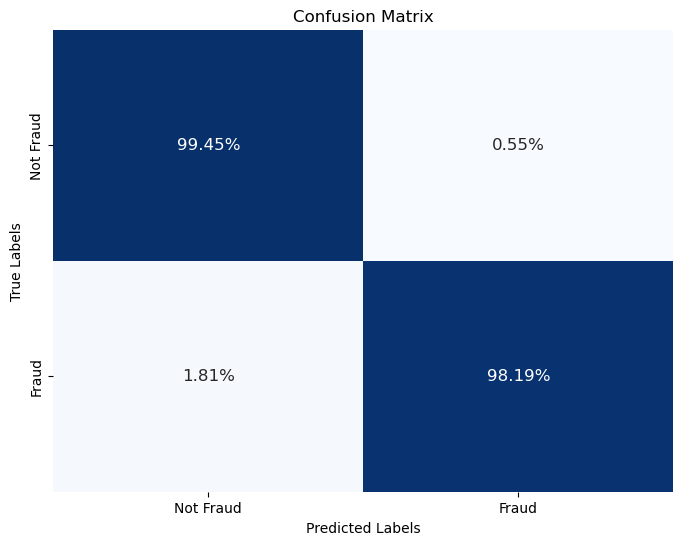

############################################################
                     Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      6230
           1       1.00      0.98      0.99      7957

    accuracy                           0.99     14187
   macro avg       0.99      0.99      0.99     14187
weighted avg       0.99      0.99      0.99     14187



In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import joblib

# Splitting the dataset into train and test sets
#X = dftree.drop(columns=['label'])  # Features
#y = dftree['label']                # Target variable
X = hstack([sender_features, receiver_features, subject_features, body_features])
y = dftree['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# joblib.dump(sender_vect, 'sender_vect.pkl')
# joblib.dump(receiver_vect, 'receiver_vect.pkl')
# joblib.dump(subject_vect, 'subject_vect.pkl')
# joblib.dump(body_vect, 'body_vect.pkl')

# Initialize Random Forest with class weight to handle imbalanced classes
#rf = RandomForestClassifier(max_depth = 20, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 200, class_weight='balanced', random_state=42)
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
#Best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
#Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
#defining paramater grid for GridSearchCV
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }
# #Best params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
# grid_search = GridSearchCV(rf, param_grid, cv = 5, scoring = "recall")


# grid_search.fit(X_train, y_train)

# print("Best params:", grid_search.best_params_)
# print("Best score:", grid_search.best_score_)

# Train the model


rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]  # For AUC-ROC score


#save the model
#joblib.dump(rf, 'phish.pkl')


# Compute the confusion matrix
cm1 = confusion_matrix(y_test, y_pred, normalize='true')
# Define labels for the classes
labels = ["Not Fraud", "Fraud"]
plt.figure(figsize=(8,6))
sns.heatmap(cm1, annot=True, fmt='.2%', cmap='Blues', cbar=False, 
            xticklabels=labels, yticklabels=labels, annot_kws={"size": 12})
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

print("#" * 60)
print(" " * 20, "Classification Report")
print(classification_report(y_test, y_pred))
#47 67
#2.16 3.71

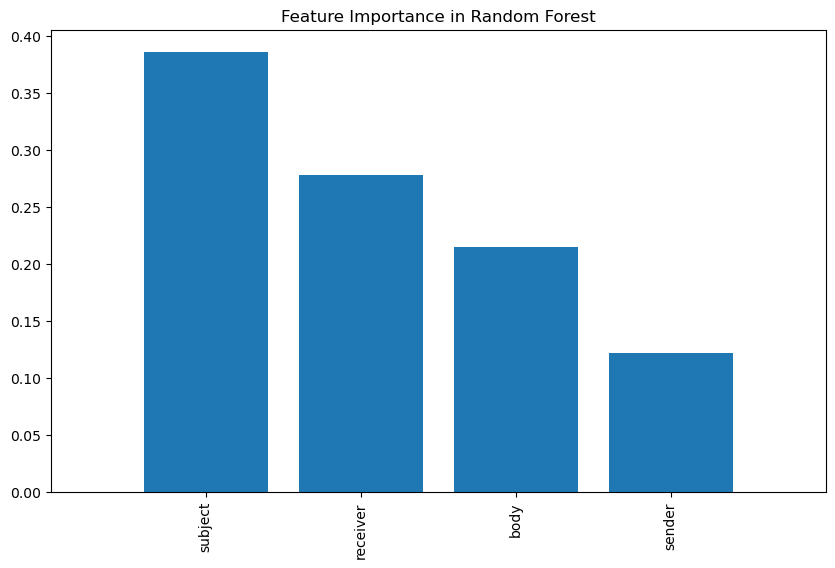

In [65]:
importances = rf.feature_importances_

indices = np.argsort(importances)[::-1]

feature_names = X_train.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Random Forest")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(feature_names)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [22]:
#print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


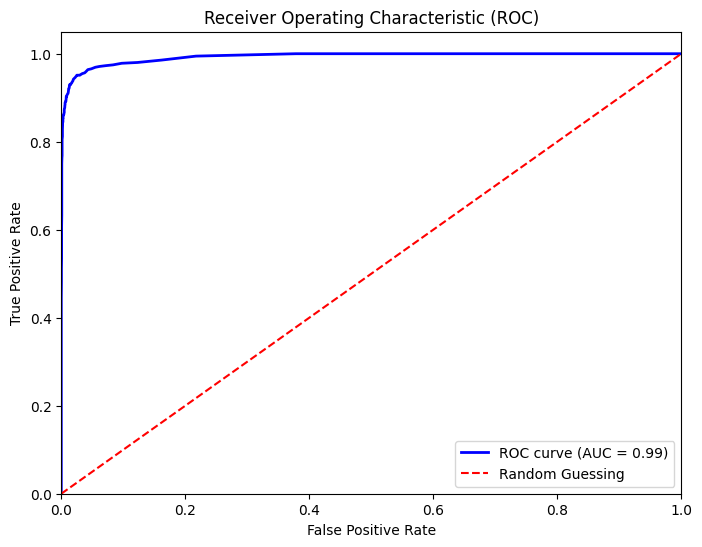

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()



In [24]:
from sklearn.model_selection import cross_val_score
# Perform 5-fold cross-validation
scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')

# Print each fold's AUC score and the average
print("AUC scores for each fold:", scores)
print("Mean AUC score:", scores.mean())

AUC scores for each fold: [0.99326849 0.99105637 0.99604196 0.99096496 0.99016617]
Mean AUC score: 0.9922995910762678
